In [1]:
import sys
sys.path.append('/workspace/Documents')
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import cv2
import nibabel as nb
import nrrd

from skimage.draw import polygon
from scipy.spatial import ConvexHull
from scipy import ndimage
from skimage.draw import polygon2mask
from skimage.draw import polygon2mask
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splprep

import PSF_generation.python.functions as ff

# Read the speadsheet for patient list

In [2]:
sheet = '/mnt/BPM_NAS/BPM/alldata/phase3_ge_origin/darwin/cleaned_labels/20240406_blur/all/Blur.csv'
sheet = pd.read_csv(sheet)
# only keep the one without blur
sheet = sheet[(sheet['Blur']==1) & (sheet['Exclude'] == 0)]
print(sheet.shape)

(5, 10)


# Pick one case: a blur one with its corresponding static one (from the other side)

patient_image_name 2d_proc_sd.01033.lmlo.dcm
pixel_spacing: [0.1, 0.1]


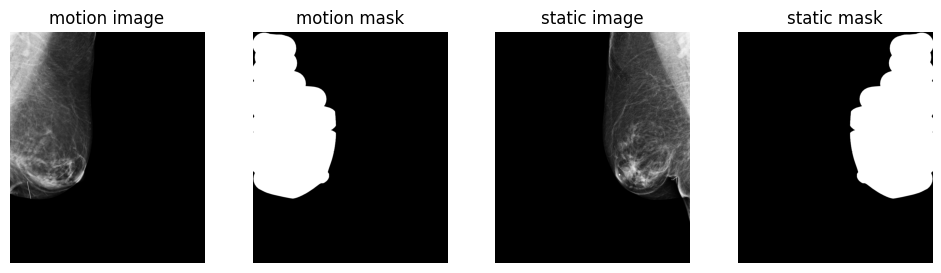

In [66]:
index = 0
motion_patient = sheet.iloc[index]
motion_patient_image_name = motion_patient['Image']
print('patient_image_name', motion_patient_image_name)

# its corresponding static image
patient_image_name = '2d_proc_sd.01033.rmlo.dcm'
save_folder = os.path.join('/mnt/BPM_NAS/BPM/alldata/phase3_ge_origin/darwin/simulations_explore' , patient_image_name)

# read the static image
patient_image_file = os.path.join('/mnt/BPM_NAS/BPM/alldata/phase3_ge_origin/darwin', motion_patient['Folder'], 'data_lut', patient_image_name)
img = pydicom.dcmread(patient_image_file)
img = img.pixel_array
ff.make_folder([save_folder, os.path.join(save_folder,'static')])
nb.save(nb.Nifti1Image(img, np.eye(4)), os.path.join(save_folder, 'static', 'img.nii.gz'))


# read the motion image and its blur mask
motion_image_file = os.path.join('/mnt/BPM_NAS/BPM/alldata/phase3_ge_origin/darwin', motion_patient['Folder'], 'data_lut', motion_patient_image_name)
motion_img = pydicom.dcmread(motion_image_file)
motion_img = motion_img.pixel_array
motion_seg = os.path.join('/mnt/BPM_NAS/BPM/alldata/phase3_ge_origin/darwin', motion_patient['Folder'], 'seg_blur', motion_patient_image_name + '.Janice.seg.nrrd')
seg, _ = nrrd.read(motion_seg)
seg = np.transpose(seg, (1, 0))
seg[motion_img<=0] = 0

# also flip this seg for simulation
seg_flip = np.flip(seg, axis = 1)

# save
ff.make_folder([save_folder,os.path.join(save_folder, 'real_blur')])
nb.save(nb.Nifti1Image(motion_img, np.eye(4)), os.path.join(save_folder, 'real_blur', 'img.nii.gz'))
nb.save(nb.Nifti1Image(seg, np.eye(4)), os.path.join(save_folder, 'real_blur', 'mask.nii.gz'))

# Display the image
plt.figure(figsize = (12,3))
plt.subplot(1,4,1)
plt.imshow(motion_img, cmap='gray')
plt.title('motion image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(seg, cmap='gray')
plt.title('motion mask')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img, cmap='gray')
plt.title('static image')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(seg_flip, cmap='gray')
plt.title('static mask')
plt.axis('off')

# get the pixel spacin
a = pydicom.dcmread(patient_image_file)
pixel_spacing = a.ImagerPixelSpacing
print('pixel_spacing:', pixel_spacing)


# save image
x = 1490
y = 1680
ff.save_grayscale_image(img[x-250:x+250, y-250:y+250], os.path.join(save_folder, 'static', 'img.png'), WL = np.max(img)/2, WW = np.max(img))

xx = 1682
yy = 683
ff.save_grayscale_image(motion_img, os.path.join(save_folder, 'real_blur', 'img.png'), WL = np.max(motion_img)/2, WW = np.max(motion_img))


Total Length: [300.]


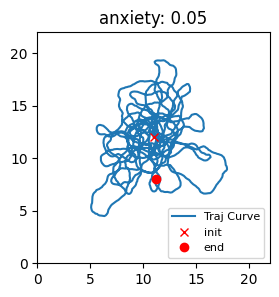

In [60]:
# set some simulation parameters
PSFsize = [22,22]
anxiety = 0.05 # what's this?
numT = 2000# the number of steps the motion trajectory should be sampled
limited_displacement = 1.5/ pixel_spacing[0] # the maximum displacement of the motion trajectory
MaxTotalLength = 30/pixel_spacing[0]# np.random.uniform(20,100) / pixel_spacing[0] # the maximum length of the motion trajectory

exposure_time = [1]

# noise paramters
sigma_gauss = 0.05

# create motion trajectory
TrajCurve = ff.create_motion_trajectory(PSFsize, anxiety, numT, MaxTotalLength,limited_displacement, plot_traj=True)

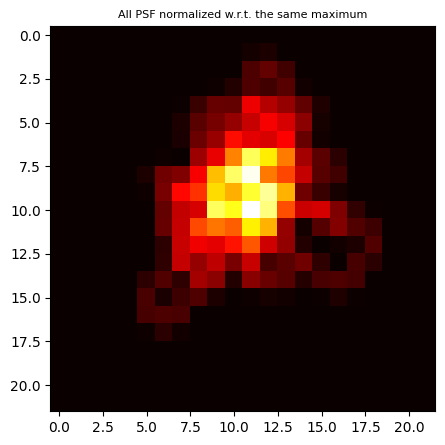

In [61]:
# create PSF for each exposure time
PSFS = ff.create_PSF(TrajCurve, exposure_time, PSFsize, plot_PSF=True)

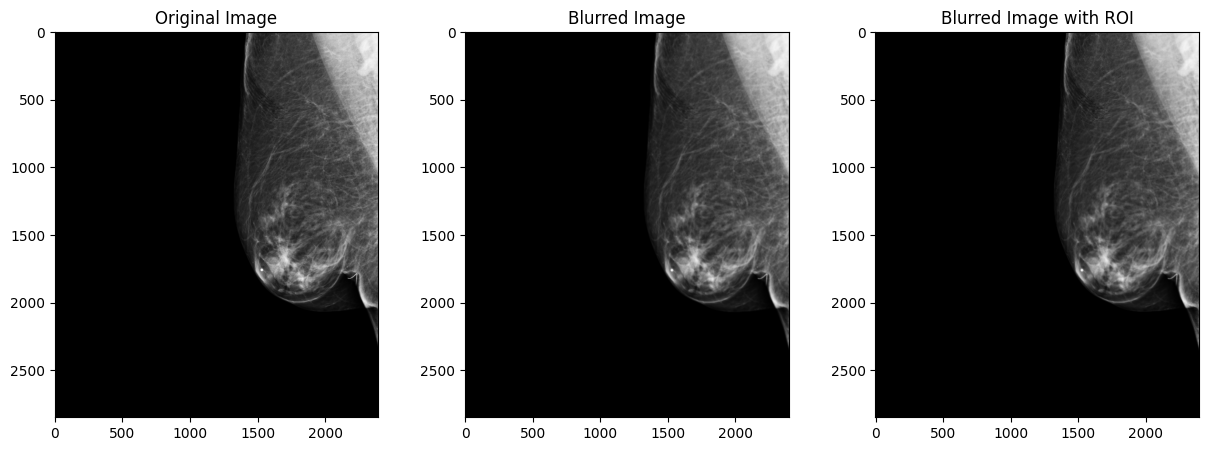

In [62]:
# create final blurred image
final_img = ff.create_motion_blur_img(img, PSFS, add_noise=False, sigma_gauss=sigma_gauss)[:,:,0]
# scale the final image so that keep the intensity range same
final_img = (final_img - np.min(final_img)) / (np.max(final_img) - np.min(final_img)) * (np.max(img) - np.min(img)) + np.min(img)

# some chances that only part of the image is blurred
if np.random.rand() > 0:
    # use smooth ROI
    final_img_roi_smooth = final_img * smooth_ROI + img * (1 - smooth_ROI)
else:
    print('no ROI')
    final_img_roi = final_img

# make sure the background is always 0
final_img[img<=0] = img[img<=0]; final_img = np.round(final_img)
# final_img_roi_direct[img<=0] = img[img<=0]; final_img_roi_direct = np.round(final_img_roi_direct)
final_img_roi_smooth[img<=0] = img[img<=0]; final_img_roi_smooth = np.round(final_img_roi_smooth)

plt.figure(figsize = (15,5))
plt.subplot(131); plt.imshow(img, 'gray')
plt.title('Original Image')
plt.subplot(132); plt.imshow(final_img, 'gray')
plt.title('Blurred Image')
plt.subplot(133); plt.imshow(final_img_roi_smooth, 'gray')
plt.title('Blurred Image with ROI')

# save nii
ff.make_folder([os.path.join(save_folder, 'simulated_blur')])
nb.save(nb.Nifti1Image(final_img_roi_smooth, np.eye(4)), os.path.join(save_folder, 'simulated_blur', 'img_'+'max' + str(limited_displacement * pixel_spacing[0]) + 'total'+ str(MaxTotalLength * pixel_spacing[0]) + '.nii.gz'))
nb.save(nb.Nifti1Image(smooth_ROI, np.eye(4)), os.path.join(save_folder, 'simulated_blur', 'mask.nii.gz'))
# save img
ff.save_grayscale_image(final_img_roi_smooth[x-250:x+250, y-250:y+250], os.path.join(save_folder, 'simulated_blur', 'img_'+'max' + str(limited_displacement * pixel_spacing[0]) + 'total'+ str(MaxTotalLength * pixel_spacing[0]) + '.png'), WL = np.max(img)/2, WW = np.max(img))



Text(0.5, 1.0, 'ROI')

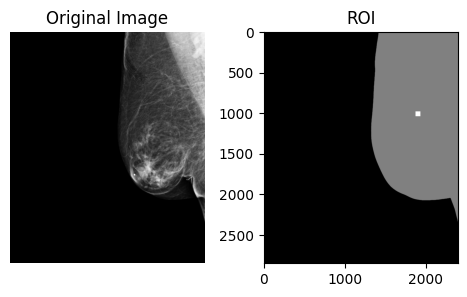

In [20]:
# Display the image
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(img, 'gray'); plt.axis('off'); plt.title('Original Image')

img_binary = np.zeros_like(img)
img_binary[img > 0] = 1
center_of_mass = ndimage.measurements.center_of_mass(img > 0)
center_of_mass = [int(center_of_mass[0]), int(center_of_mass[1])]
img_binary[center_of_mass[0]-30: center_of_mass[0]+30, center_of_mass[1]-30: center_of_mass[1]+30] = 2
plt.subplot(122); plt.imshow(img_binary, 'gray'); plt.title('ROI')


center of mass: [1009, 1890]
570 950


/usr/local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


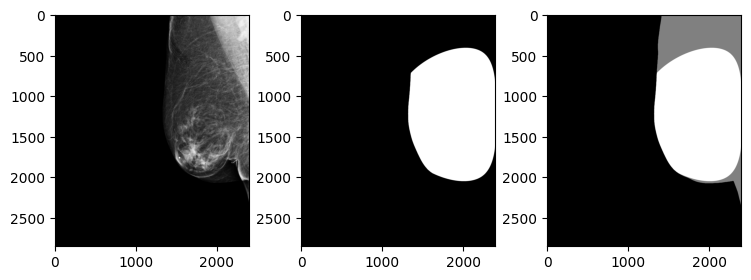

In [22]:
# create a random ROI
print('center of mass:', center_of_mass)
print(img.shape[0]//5, img.shape[0]//3)
ROI = ff.create_random_ROI(img, radius_range = [img.shape[0]//5 ,img.shape[0]//3],center_of_mass = center_of_mass, plot_ROI=True)



[0.00000000e+00 1.31055334e-04 2.62110668e-04 ... 9.99860667e-01
 9.99868945e-01 1.00000000e+00]


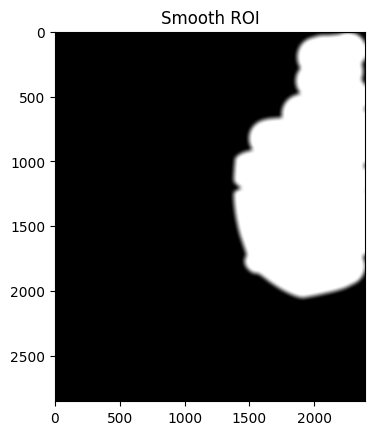

In [11]:
# for ROI how to gaussian smooth it to have a smooth boundary between 1 and 0. plot the result
ROI = np.copy(seg_flip)
ROI_copy = np.copy(ROI)
smooth_ROI = cv2.GaussianBlur(ROI_copy.astype(float), (51,51), 20)
print(np.unique(smooth_ROI))
plt.imshow(smooth_ROI, cmap='gray')
plt.title('Smooth ROI')
plt.show()

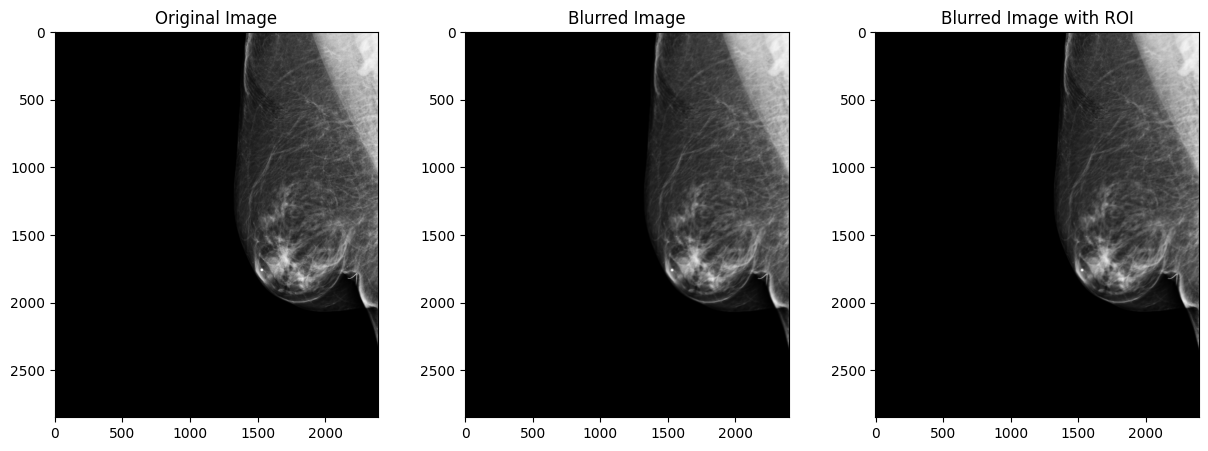

In [26]:
# create final blurred image
final_img = ff.create_motion_blur_img(img, PSFS, add_noise=False, sigma_gauss=sigma_gauss)[:,:,0]
# scale the final image so that keep the intensity range same
final_img = (final_img - np.min(final_img)) / (np.max(final_img) - np.min(final_img)) * (np.max(img) - np.min(img)) + np.min(img)

# some chances that only part of the image is blurred
if np.random.rand() > 0:
    # use smooth ROI
    final_img_roi_smooth = final_img * smooth_ROI + img * (1 - smooth_ROI)
else:
    print('no ROI')
    final_img_roi = final_img

# make sure the background is always 0
final_img[img<=0] = img[img<=0]; final_img = np.round(final_img)
# final_img_roi_direct[img<=0] = img[img<=0]; final_img_roi_direct = np.round(final_img_roi_direct)
final_img_roi_smooth[img<=0] = img[img<=0]; final_img_roi_smooth = np.round(final_img_roi_smooth)

plt.figure(figsize = (15,5))
plt.subplot(131); plt.imshow(img, 'gray')
plt.title('Original Image')
plt.subplot(132); plt.imshow(final_img, 'gray')
plt.title('Blurred Image')
plt.subplot(133); plt.imshow(final_img_roi_smooth, 'gray')
plt.title('Blurred Image with ROI')

# save nii
ff.make_folder([os.path.join(save_folder, 'simulated_blur')])
nb.save(nb.Nifti1Image(final_img_roi_smooth, np.eye(4)), os.path.join(save_folder, 'simulated_blur', 'img_'+'max' + str(limited_displacement * pixel_spacing[0]) + 'total'+ str(MaxTotalLength * pixel_spacing[0]) + '.nii.gz'))
nb.save(nb.Nifti1Image(smooth_ROI, np.eye(4)), os.path.join(save_folder, 'simulated_blur', 'mask.nii.gz'))
# save img
ff.save_grayscale_image(final_img_roi_smooth[x-250:x+250, y-250:y+250], os.path.join(save_folder, 'simulated_blur', 'img_'+'max' + str(limited_displacement * pixel_spacing[0]) + 'total'+ str(MaxTotalLength * pixel_spacing[0]) + '.png'), WL = np.max(img)/2, WW = np.max(img))

